## COMPARING SOME FUNDAMENTAL REGRESSION METHODS ON ADMISSION PREDICTION DATA AND DEPLOYING ML MODEL TO IBM CLOUD

There are lots of regression methods to predict data such as Linear Regression, Decision Tree Regression and so on. In this notebook, we will try to predict the "Chance of Admit" data by using some of fundamental regression methods, which are Linear Regression, Multiple Linear Regression, Decision Tree Regression and Random Forest Regression.

## Importing the required libraries

In [137]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Preparing the dataset

In [42]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='2lO2H-39ugy5THic7bSZNoSkQfgPdr4Jm-EYiwiwGS5_',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'ibmdeployment-donotdelete-pr-2nbalvcbfj9ry7'
object_key = 'Admission_Predict_Ver1.1.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()


,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


## Creating a correlation matrix

In [43]:
corr_matrix=df.corr()
corr_matrix

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,1.000000,-0.103839,-0.141696,-0.067641,-0.137352,-0.003694,-0.074289,-0.005332,0.008505
GRE Score,-0.103839,1.000000,0.827200,0.635376,0.613498,0.524679,0.825878,0.563398,0.810351
TOEFL Score,-0.141696,0.827200,1.000000,0.649799,0.644410,0.541563,0.810574,0.467012,0.792228
University Rating,-0.067641,0.635376,0.649799,1.000000,0.728024,0.608651,0.705254,0.427047,0.690132
SOP,-0.137352,0.613498,0.644410,0.728024,1.000000,0.663707,0.712154,0.408116,0.684137
LOR,-0.003694,0.524679,0.541563,0.608651,0.663707,1.000000,0.637469,0.372526,0.645365
CGPA,-0.074289,0.825878,0.810574,0.705254,0.712154,0.637469,1.000000,0.501311,0.882413
Research,-0.005332,0.563398,0.467012,0.427047,0.408116,0.372526,0.501311,1.000000,0.545871
Chance of Admit,0.008505,0.810351,0.792228,0.690132,0.684137,0.645365,0.882413,0.545871,1.000000


When looking at the data and correlation matrix, it seems that "Chance of Admit" values depend on lots of variables. To observe the effects of columns on "Chance of Admit" values in detail, so creating a correlation graph.

In [44]:
#plotting the correlation matrix as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix,annot=True)
plt.show()

As seen, there are direct proportions between "Chance of Admit" data and the other columns. In order to observe these direct proportions more clearly, we will visualize the data.

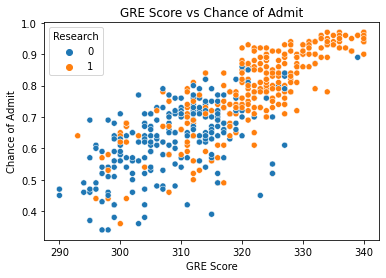

In [45]:
#plotting data which have high correlation
%matplotlib inline
import seaborn as sns
data=df
sns.scatterplot(data['GRE Score'], data['Chance of Admit'],data=df,hue=data['Research'])
plt.title("GRE Score vs Chance of Admit")
plt.show()

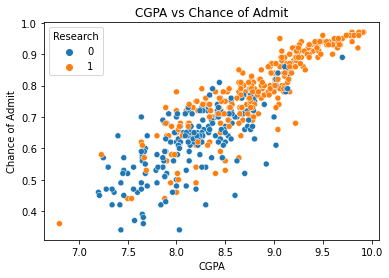

In [46]:
%matplotlib inline
import seaborn as sns
data =df
sns.scatterplot(data["CGPA"],data["Chance of Admit"],data=df,hue=data["Research"])
plt.title("CGPA vs Chance of Admit")
plt.show()

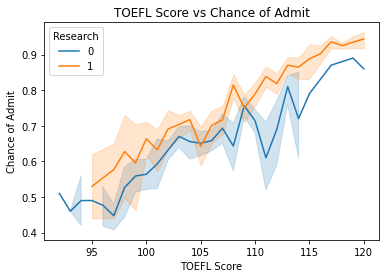

In [47]:
%matplotlib inline
import seaborn as sns
data=df
sns.lineplot(data["TOEFL Score"],data["Chance of Admit"],hue=data["Research"])
plt.title("TOEFL Score vs Chance of Admit")
plt.show()

In [48]:
%matplotlib
import seaborn as sns

sns.barplot(data=df,x='SOP',y='Chance of Admit',palette='Set2',hue='Research')
plt.title('SOP vs Chance of Admit')
plt.show

Using matplotlib backend: agg


<function matplotlib.pyplot.show(*, block=None)>

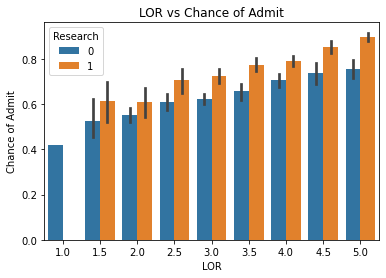

In [49]:
%matplotlib inline
import seaborn as sns
data=df
sns.barplot(data["LOR"],data["Chance of Admit"],hue=data["Research"])
plt.title("LOR vs Chance of Admit")
plt.show()

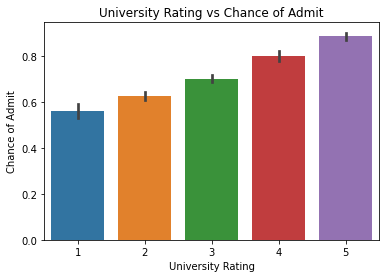

In [50]:
%matplotlib inline
import seaborn as sns
data=df
sns.barplot(data["University Rating"],data["Chance of Admit"])
plt.title("University Rating vs Chance of Admit")
plt.show()

It was said that there are direct proportions between the columns and "Chance of Admit" data. Also, when observing the graphs, there are linear relationships between them. Therefore, using Linear Regression method may be suitable on the data, but since "Chance of Admit" data depends on more than one varible, it is more appropriate to imply Multiple Linear Regression method instead of Linear Regression method.

## Importing the required libraries for regression analyzes

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

## Spliting the dataset into training and testing data

In [52]:
x = df[["GRE Score","TOEFL Score","University Rating","SOP","LOR","CGPA", "Research"]]
y = df["Chance of Admit"].values.reshape(-1,1)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [53]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

## Multiple Linear Regression

In [54]:
#implying multiple linear regression and determining its score

multiple_lin_reg = LinearRegression()
multiple_lin_reg.fit(x_train,y_train)

y_pred_mlr = multiple_lin_reg.predict(x_test)

r2_score_mlr = r2_score(y_test,y_pred_mlr)
print("Mutiple Linear Regression's Score = {:.3f}".format(r2_score_mlr))

Mutiple Linear Regression's Score = 0.819


## Decision Tree Regression

In [55]:
#implying decision tree regression and determining its score

tree_reg = DecisionTreeRegressor()
tree_reg.fit(x_train,y_train)

y_pred_tree = tree_reg.predict(x_test)

r2_score_tree = r2_score(y_test,y_pred_tree)
print("Decision Tree Regression's Score = {:.3f}".format(r2_score_tree))

Decision Tree Regression's Score = 0.595


## Random Forest Regression

In [56]:
#implying random forest regression and determining its score

ran_for_reg = RandomForestRegressor(n_estimators=100,random_state=42)
ran_for_reg.fit(x_train,y_train)

y_pred_rfr = ran_for_reg.predict(x_test)

r2_score_rfr = r2_score(y_test,y_pred_rfr)
print("Random Forest Regression's Score = {:.3f}".format(r2_score_rfr))

Random Forest Regression's Score = 0.787


/tmp/wsuser/ipykernel_165/3545579415.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  ran_for_reg.fit(x_train,y_train)


## Conclusion

R^2 score is an indicator of accuracy of regression models, and the accuracy is measured as close to 1 of this value .Therefore , as seen ,Multiple Linear Regression Models is brtter than Decision Tree Regression and Random Forest Regression on this dataset when comparing their R^2 scores



In [57]:
!pip install ibm_watson_machine_learning

## Establising connection to IBM Watson ML sevice

In [58]:
from ibm_watson_machine_learning import APIClient
import json

In [59]:
from ibm_watson_machine_learning import APIClient
wml_credentials = {
    "apikey": "GXIq0WvfLYobrmTPaccsVpwEML_PHzJjoRIhFnQkfjkM",
    "url":"https://us-south.ml.cloud.ibm.com"
}

In [60]:
wml_client=APIClient(wml_credentials)

In [61]:
wml_client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  ----------------  ------------------------
ID                                    NAME              CREATED
5e27b477-1bb8-4a48-8b0f-81b3147dffe1  multilenear demo  2022-11-14T16:45:46.614Z
------------------------------------  ----------------  ------------------------


In [62]:
SPACE_ID="5e27b477-1bb8-4a48-8b0f-81b3147dffe1"

In [63]:
wml_client.set.default_space(SPACE_ID)

'SUCCESS'

In [64]:
wml_client.software_specifications.list(500)

-------------------------------  ------------------------------------  ----
NAME                             ASSET_ID                              TYPE
default_py3.6                    0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12        020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt       069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6          09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12       09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9        0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6            0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                       0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod     1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6                10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl        111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt

## Creating Deployment Space

In [65]:
import sklearn
sklearn.__version__

'1.0.2'

In [66]:
MODEL_NAME="ibmdeployment"
DEPLOYEMENT_NAME="multilenear demo"
DEMO_MODEL= "model"

In [67]:
software_spec_uid=wml_client.software_specifications.get_id_by_name('runtime-22.1-py3.9')

In [68]:
software_spec_uid = wml_client.software_specifications.get_uid_by_name("runtime-22.1-py3.9")
software_spec_uid
model_props={
    wml_client.repository.ModelMetaNames.NAME: "MODEL_NAME",
    wml_client.repository.ModelMetaNames.TYPE: "scikit-learn_1.0",
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid
}

In [69]:
#Save model
model_details = wml_client.repository.store_model(
    model=DEMO_MODEL, 
    meta_props=model_props, 
    training_data="x_train", 
    training_target="y_train"
)

Failure during getting trained models details. (GET https://us-south.ml.cloud.ibm.com/ml/v4/trainings/model?version=2021-06-24&space_id=5e27b477-1bb8-4a48-8b0f-81b3147dffe1)
Status code: 404, body: {"trace":"b7287e057e8a136149bddb5476089afd","errors":[{"code":"training_job_run_not_found","message":"Backend persistence error (404): GET request failed","more_info":"http://watson-ml-api.mybluemix.net/"}],"status_code":"404"}
Unexpected type of 'model parameter', expected: model path / training_id, actual: 'model'.


UnexpectedType: Unexpected type of 'model parameter', expected: model path / training_id, actual: 'model'.

In [70]:
deployment_props={
    wml_client.deployments.ConfigurationMetaNames.NAME:"DEPLOYMENT_NAME",
    wml_client.deployments.ConfigurationMetaNames.ONLINE:{}
}

In [71]:
model_details

NameError: name 'model_details' is not defined

In [72]:
model_id = wml_client.repository.get_model_id(model_details)
model_id

NameError: name 'model_details' is not defined

## Testing

In [73]:
x_train

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
249,321,111,3,3.5,4.0,8.83,1
433,316,111,4,4.0,5.0,8.54,0
19,303,102,3,3.5,3.0,8.50,0
322,314,107,2,2.5,4.0,8.27,0
332,308,106,3,3.5,2.5,8.21,1
...,...,...,...,...,...,...,...
106,329,111,4,4.5,4.5,9.18,1
270,306,105,2,2.5,3.0,8.22,1
348,302,99,1,2.0,2.0,7.25,0
435,309,105,2,2.5,4.0,7.68,0


In [74]:

multiple_lin_reg.predict(x_train)

array([[0.79319678],
       [0.74507858],
       [0.64401532],
       [0.67274778],
       [0.65094595],
       [0.54916269],
       [0.72581613],
       [0.80517894],
       [0.63303132],
       [0.68811779],
       [0.64924268],
       [0.95289497],
       [0.84653676],
       [0.96863011],
       [0.46641449],
       [0.82149658],
       [0.67146854],
       [0.88635893],
       [0.49256047],
       [0.68574539],
       [0.71763218],
       [0.88677469],
       [0.72363358],
       [0.74858906],
       [0.69122802],
       [0.69069927],
       [0.5691487 ],
       [0.99211793],
       [0.84286454],
       [0.51255247],
       [0.72510392],
       [0.72307643],
       [0.84332283],
       [0.52085083],
       [0.82678515],
       [0.5026812 ],
       [0.82394811],
       [0.96025707],
       [0.66361992],
       [0.6781819 ],
       [0.79599956],
       [0.61913284],
       [0.81894967],
       [0.52916542],
       [0.94791192],
       [0.65537821],
       [0.96318716],
       [0.782

## UASEP Multiple Linear Regression Model Deployment Test

In [39]:
import requests

# NOTE: you must manually set API_KEY below using information retrieved from your IBM Cloud account.
API_KEY = "O-xbXqcCv2iPGZfem_krJ8KX-kQ2h5bKybYpPwY-gOfl"
token_response = requests.post('https://iam.cloud.ibm.com/identity/token', data={"apikey":
 API_KEY, "grant_type": 'urn:ibm:params:oauth:grant-type:apikey'})
mltoken = token_response.json()["access_token"]

header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

# NOTE: manually define and pass the array(s) of values to be scored in the next line
payload_scoring = {"input_data": [{"field": [["GRE Score","TOEFL Score","University Rating","SOP","LOR ","CGPA", "Research"]], "values": [[326, 110, 2, 3.5, 4, 9.23, 1]]}]}

response_scoring = requests.post('https://us-south.ml.cloud.ibm.com/ml/v4/deployments/uaep_deployment/predictions?version=2022-11-12', json=payload_scoring,
 headers={'Authorization': 'Bearer ' + mltoken})
print("Scoring response")
print(response_scoring.json())

Scoring response
{'predictions': [{'fields': ['prediction'], 'values': [[[0.8448151378927107]]]}]}


In [40]:
probability = response_scoring.json()['predictions'][0]['values'][0][0][0]
probability

0.8448151378927107